# Цели работы

Целью работы является исследование сетевого протокола TokenRing, выявление основных свойств его работы в зависимоси от характеристик нод и сети между ними.

# Модель

## Архитектура

Код модели находится на Github: https://github.com/SniXosha/token-ring, пример запуска эксперимента есть в классе SimpleExperiment. 

TokenRing состоит из:
* $N$ нод, образующих кольцо
* $N$ медиумов для передачи сообщений между соседними нодами (сеть)
* $m \in [1 \dots N]$ токенов

Для эмуляции работы TokenRing в режиме, приближенном к реальному, в модель были добавлены задержки при обработке токена (трата времени на полезную работу ноды) и при общении с медиумами (задержка на передачу сообщения по сети).

## Стратегии нод

При старте каждая нода запускается в отдельном треде и работает по некоторой параметризированной стратегии. Стратегии отличаются задержкой на обработку сообщений:
* Simple - константное время обработки токена
* SlowFast - токен обрабатывается медленно ($t_{slow} > t_{fast}$) с некоторой вероятностью

В остальном стратегии ведут себя одинаково - токен обрабатывается если его прислали этой ноде; если есть возможность отправить сообщение (пришел пустой токен) - сообщение отправляется; иначе - токен отправляется следующей ноде без изменений.

## Медиумы

Медиум был реализован с помощью блокирующей очереди. Размер очереди $s$ влиял на общую характеристику сети:
* $s = 1$. Токены не могут "копиться" между нодами
* $s > 1$. Нода-отправитель может, не дожидаясь получателя, отправить новый токен.

Для режима $s = 1$ можно было бы имплементировать отдельный медиум, который работал бы без оверхедов, появляющихся при использовании очереди. Однако это не было сделано по двум причинам:
* целью является не анализ двух структур данных для эмуляции сети, а поведение всего token ring в зависимости от высокоуровневого параметра - single/multiple token medium. 
* нет необходимости добиваться максимального перфоманса медиума

## Токены

Токены состоят из $id$ и $destinationId$. Так ноды могут узнать, кому отправляется токен. 

# Эксперименты

Эксперименты проводились на компьютере с Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz

Основной целью является проверка того, как влияет размер очереди в медиуме на работу TokenRing. Single режим - очередь размера 1, multiple режим - очередь, в которую могут поместиться все токены. Работа сети будет измеряться двумя метриками:
* latency - время между отправкой сообщением и его получением обратно
* throughput - кол-во сообщений передаваемых в сети в секунду

Для этого каждая нода замеряет latency отправки сообщения и сохраняет его в общем хранилище, которое потом будет анализироваться. Время замеряется с помощью System.currentTimeMillis() - этой точности вполне достаточно, т.к. мы будем вводить такие задержки, что ожидаемое latency будет значительно больше $1ms$. 

Чтобы учесть время прогрева jvm, начальные $1000$ записей будут игнорироваться (цифра подобрана по результатам тестовых запусков).

## Медленная сеть, быстрые ноды

Проверим влияение размера очереди в медиуме на TokenRing, в котором значительную часть задержки доставки сообщения занимает сеть. 

Выберем следующие задержки:
* время обработки токена нодой-получателем - 10ms
* время передачи токена через медиум соседней ноде - 5ms

Выберем размер очереди $s$:
* $s = 1$, для single режима
* $s = 16$, для multiple режима

Количество нод - 16, варьируем число токенов в сети.

Тогда в лучшем случаем, запрос займет как минимум $16 * 5 + 10 = 90ms$, где $89\%$ времени приходится именно на сеть

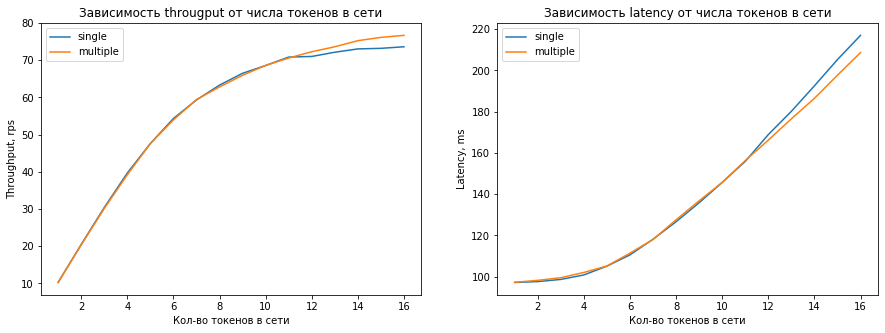

In [25]:
compare_experiments([['r','single'], ['s', 'multiple']], list(range(1, 17)))

Можно заметить, что эффективность multiple медиума тем выше, чем больше токенов в сети. При 16 токенах в сети:
* ${\bf single}$: throughput (73.6 $\pm$ 7.0) rps, latency (216.9 $\pm$ 11.1) ms
* ${\bf multiple}$: throughput (76.7 $\pm$ 6.6) rps, latency (208.5 $\pm$ 10.1) ms

Throughput выше на $4.2\%$, а latency меньше на $3.9\%$

## Быстрая сеть, медленные ноды

Теперь рассмотрим ситуацию, когда большую часть времени в ожидании запроса уходит на обработку токена другой нодой. Для этого выберем следующие задержки:
* время обработки токена нодой-получателем - 100ms
* время передачи токена через медиум соседней ноде - 2ms

Тогда в лучшем случаем, запрос займет как минимум $16 * 2 + 100 = 132ms$, где $75\%$ времени уходит на обработку токена

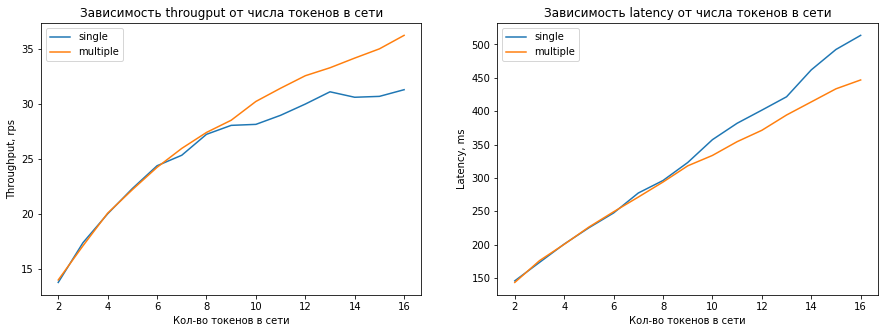

In [24]:
compare_experiments([['z','single'], ['x', 'multiple']], list(range(1, 17)))

В данном случае эффект от очереди в медиуме еще более заметный. При 16 токенах в сети:
* ${\bf single}$: throughput (31.4 $\pm$ 3.4) rps, latency (510.0 $\pm$ 39.5) ms
* ${\bf multiple}$: throughput (37.0 $\pm$ 3.8) rps, latency (436.9 $\pm$ 36.9) ms

Throughput выше на $17.8\%$, а latency меньше на $14.3\%$

Можно сделать вывод, что в TokenRing оптимизация сети особенно важна, если ноды медленные и тем самым могут замедлять других участников сети.

## Смешанный режим

Так же рассмотрим смешанный режим работы. Обработка токена будет занимать $5ms$ с вероятностью $80\%$, и $100ms$ с вероятностью $20\%$. Задержка сети - $2ms$. 

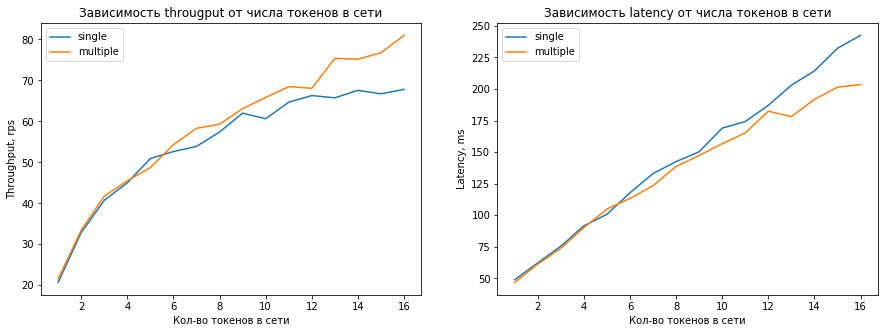

In [26]:
compare_experiments([['a','single'], ['b', 'multiple']], list(range(1, 17)))

Можно заметить, что эффект все еще заметный. При 16 токенах в сети:
* ${\bf single}$: throughput (68.4 $\pm$ 12.6) rps, latency (240.7 $\pm$ 35.3) ms
* ${\bf multiple}$: throughput (80.7 $\pm$ 14.1) rps, latency (204.2 $\pm$ 31.1) ms

Throughput выше на $12.3\%$, а latency меньше на $15.1\%$

Порядок прироста такой же как в эксперименте с медленными нодами, хотя в этом случае ноды в 80% случаях обрабатывали запросы быстро. Можно сделать вывод, что очередь в медиуме все ещё эффективна, даже если число медленных запросов небольшое.

# Заключение

Из проведенных экспериментов можно сделать вывод, что оптимизация сети в TokenRing важна в том случае, когда некоторые ноды занимают значительное время на обработку токена перед передачей его следующей ноде. Это полезно и в случае когда время обработки любых токенов значительно выше затрат на сеть, и в случае когда такие долгие запросы редки.

Если же работа на нодах быстрая, а сеть медленная, буфферизация токенов между нодами не дает большого прироста в эффективности TokenRing.

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(arr, w):
    cum_sum = np.cumsum(arr)
    return (cum_sum[w:] - cum_sum[:-w]) / w

def moving_throughput(arr, w):
    return w * 1000 / (arr[w:] - arr[:-w])

def compare_experiments(experiments, x):
    ts = []
    ls = []
    labels = []
    for experiment in experiments:
        code, label = experiment
        t = []
        l = []
        for i in x:
            with open("../results-" + code + str(i) + ".txt", "r") as file:
                times = np.array([int(x) for x in file.readline().split()])
                timestamps = np.array([int(x) for x in file.readline().split()])
            throughput = moving_throughput(timestamps, 50)[1000:]
            latency = moving_average(times, 50)[1000:]
            t.append(np.mean(throughput))
            l.append(np.mean(latency))
        ts.append(t)
        ls.append(l)
        labels.append(label)
        
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    
    for i in range(len(experiments)):
        plt.plot(x, ts[i], label=labels[i])
    plt.title("Зависимость througput от числа токенов в сети")
    plt.xlabel("Кол-во токенов в сети")
    plt.ylabel("Throughput, rps")
    plt.legend()
    
    
    plt.subplot(1, 2, 2)
    for i in range(len(experiments)):
        plt.plot(x, ls[i], label=labels[i])
    plt.title("Зависимость latency от числа токенов в сети")
    plt.xlabel("Кол-во токенов в сети")
    plt.ylabel("Latency, ms")
    plt.legend()
    plt.show()